In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import scipy.linalg as linalg

In [150]:
class LinearQuadraticRegulator():
    def __init__(self, n, m):
        """
        Initialises:
            A (np.array): a matrix (n x n) representing the dynamics of the system
            B (np.array): a matrix (n x m) representing how the controls effect the system
            Q (np.array): a matrix (n x n) representing the payoffs of different states
            R (np.array): a matrix (m x m) representing the costs of the controls
        """
        self.n = n
        self.m = m
        
        self.A = rnd.standard_normal((n, n))/n/n
        self.B = rnd.standard_normal((n, m))/n/m
        self.Q = rnd.standard_normal((n, n))/n/n
        self.R = rnd.standard_normal((m, m))/m/m
        
        self.lambda_k = 0
        self.stddev = 0.1
        
    def step(self, x_t, K):
        """
        Args:
            x_t (np.array): a vector (n x 1) representing the current state
            stddev (float): the standard deviation of the added noise

        Returns:
            x_tp1 (np.array): a vector (n x 1) representing the next state
        """
        return np.dot(self.A, x_t) + np.dot(self.B, np.dot(K, x_t)) + self.stddev*rnd.standard_normal(x_t.shape)
    
    def rollout(self, x0, T, K):
        xs = [x0]
        for t in range(T-1):
            xs.append(self.step(xs[-1], K))
        return xs
    
    def reset(self):
        return np.zeros((self.n, 1)) + self.stddev*rnd.standard_normal((self.n, 1))
    
    def asymptotic_value(self, x, K):
        P = self.solve_dynamics(K)
        return self.stddev**2 * np.dot(x.T, np.dot(P, x))
        
    def solve_dynamics(self, K):
        return linalg.solve_discrete_lyapunov(self.A + np.dot(self.B, K), 
                                              self.Q + np.dot(K.T, np.dot(self.R, K)))
    
    def reward_fn(self, x, K):
        u = np.dot(K, x)
        return np.dot(x.T, np.dot(self.Q, x)) + np.dot(u.T, np.dot(self.R, u)) - self.lambda_k

In [172]:
n, m = (12, 3)
lqr = LinearQuadraticRegulator(n, m)
K = rnd.standard_normal((m, n))/n/m

In [173]:
def estimate_value(xs, lqr):
    """
    Args:
        xs (list): a list of T vectors (n x 1). a roll out trajectory
    """
    return np.sum([lqr.reward_fn(x, K) for x in xs])

In [174]:
def estimate_model(xs, lambda_r=0.001):
    """
    Estimate the model via least squares, min_x ||Ax - b||_2^2.
    A = xts, b = xtp1s
    """
    # how does this actually work. what is it doing!?
    
    shape = xs[0].shape
    xts = np.hstack(xs[:-1])
    xtp1s = np.hstack(xs[1:])
    dx = np.dot(xts, xtp1s.T)
    xx = np.dot(xts, xts.T) + lambda_r * np.eye(shape[0])
    
    # L, _, r, s = np.linalg.lstsq(xts.T, xtp1s.T, rcond=-1)
    return np.dot(dx, np.linalg.inv(xx))

def model_based_evaluation(xs, K, Q, R):
    L = estimate_model(xs)
    return linalg.solve_discrete_lyapunov(L, Q + np.dot(K.T, np.dot(R, K)))

In [177]:
P = lqr.solve_dynamics(K)
xs = lqr.rollout(lqr.reset(), 10000, K)

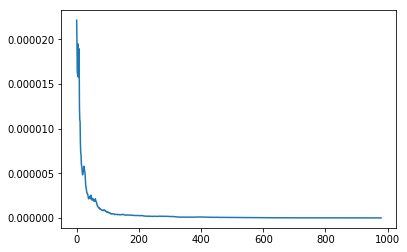

In [179]:
err = []

for i in range(200, len(xs)-1, 10):
    P_hat = model_based_evaluation(xs[:i+1], K, lqr.Q, lqr.R)
    err.append(np.linalg.norm(P - P_hat)**2)
    
plt.plot(err)

In [171]:
def model_free_evaluation(xs):
    V = np.sum([lqr.reward_fn(x) for x in xs])
    lambda_t = np.trace()
    return linalg.solve_discrete_lyapunov(L, Q + np.dot(K.T, np.dot(R, K)))